# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [1]:
# System imports
from os import path
import math
from pathlib import Path

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


# import starter code
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter

### Reading LDR images

You can use the provided samples or your own images.  You get more points for using your own images, but it might help to get things working first with the provided samples.

In [2]:
data_directory = Path("my_images")

exposures = [6, 20, 60, 180, 501]
exposure_times = [1.0 / exposure for exposure in exposures]
mirror_images = [data_directory / f"ball1-{exposure}.png" for exposure in exposures]

raw_images = [read_image(mirror_image) for mirror_image in mirror_images]
size = (raw_images[0].shape[0] + raw_images[0].shape[1]) // 2
ldr_images = np.zeros((len(raw_images), size, size, 3))
for i, raw_image in enumerate(raw_images):
    ldr_images[i] = cv2.resize(raw_image, (size, size))

# imdir = "samples"
# imfns = ["0024.jpg", "0060.jpg", "0120.jpg", "0205.jpg", "0553.jpg"]
# exposure_times = [1 / 24.0, 1 / 60.0, 1 / 120.0, 1 / 205.0, 1 / 553.0]

# ldr_images = []
# for f in np.arange(len(imfns)):
#     im = read_image(imdir + "/" + imfns[f])
#     if f == 0:
#         imsize = int((im.shape[0] + im.shape[1]) / 2)  # set width/height of ball images
#         ldr_images = np.zeros((len(imfns), imsize, imsize, 3))
#     ldr_images[f] = cv2.resize(im, (imsize, imsize))


background_image = read_image(data_directory / "scene1-60.png")

### Naive LDR merging 

Compute the HDR image as average of irradiance estimates from LDR images

In [3]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> tuple[np.ndarray, np.ndarray]:
    """
    Makes HDR image using multiple LDR images, and its corresponding exposure values.

    The steps to implement:
    1) Divide each image by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.

    2) Return average of above images


    For further explanation, please refer to problem page for how to do it.

    Args:
        ldr_images(np.ndarray): N x H x W x 3  shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            naive ldr merging implementation.
        (np.ndarray): N x H x W x 3  shaped numpy array represending log irradiances
            for each exposures

    """
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposures)

    exposures = np.array(exposures).reshape(N, 1, 1, 1)
    irradiances = ldr_images / exposures
    hdr_image = np.mean(irradiances, axis=0)
    log_irradiances = np.log(np.clip(irradiances, 1e-6, None))

    return hdr_image, log_irradiances

In [4]:
def display_hdr_image(im_hdr):
    """
    Maps the HDR intensities into a 0 to 1 range and then displays.
    Three suggestions to try:
      (1) Take log and then linearly map to 0 to 1 range (see display.py for example)
      (2) img_out = im_hdr / (1 + im_hdr)
      (3) HDR display code in a python package
    """
    im_display = im_hdr / (1 + im_hdr)
    im_display = np.clip(im_display, 0, 1)
    
    plt.imshow(im_display)
    plt.axis("off")
    plt.show()

HDR Image


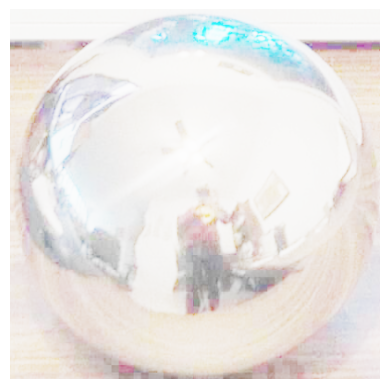

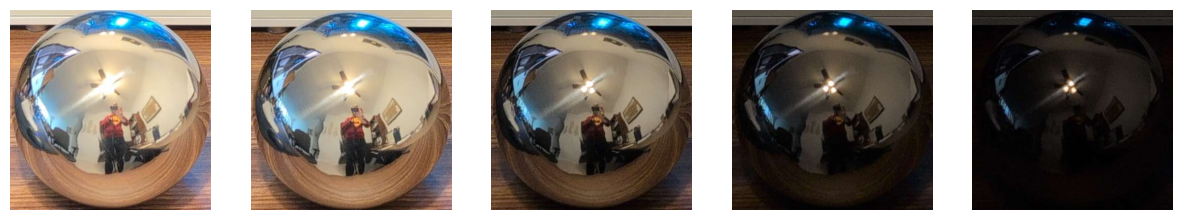

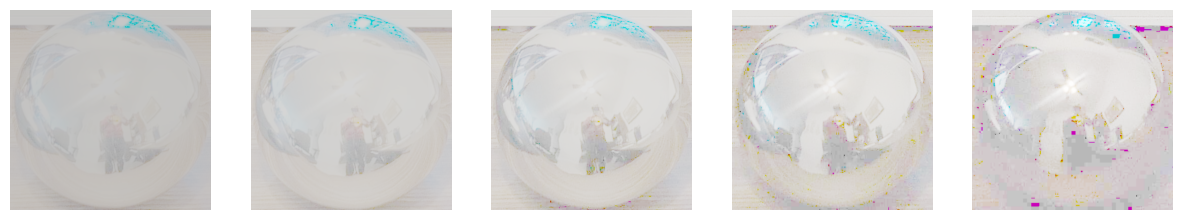

In [5]:
# get HDR image, log irradiance
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(naive_hdr_image, data_directory / "outputs" / "naive.hdr")

# display HDR image
print("HDR Image")
display_hdr_image(naive_hdr_image)

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(naive_log_irradiances)

### Weighted LDR merging 

Compute HDR image as a weighted average of irradiance estimates from LDR images, where weight is based on pixel intensity so that very low/high intensities get less weight


In [6]:
def make_hdr_weighted(
    ldr_images: np.ndarray, exposure_times: list
) -> tuple[np.ndarray, np.ndarray]:
    """
    Makes HDR image using multiple LDR images, and its corresponding exposure values.

    The steps to implement:
    1) compute weights for images with based on intensities for each exposures
        - This can be a binary mask to exclude low / high intensity values

    2) Divide each images by its exposure time.
        - This will rescale images as if it has been exposed for 1 second.

    3) Return weighted average of above images


    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposure_times(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged without
            under - over exposed regions

    """
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)

    ldr = ldr_images.astype(np.float64, copy=False)
    z_255 = ldr * 255.0 if ldr.max() <= 1.0 else ldr

    # w(z) = 128 - |z - 128|  (clipped to [0, 128]); per-channel weights
    w = 128.0 - np.abs(z_255 - 128.0)
    w = np.clip(w, 0.0, 128.0)

    exposures = np.array(exposure_times, dtype=np.float64).reshape(N, 1, 1, 1)
    eps = 1e-6
    irradiances = ldr / np.maximum(exposures, eps)

    num = np.sum(w * irradiances, axis=0)              # (H, W, 3)
    den = np.sum(w, axis=0)                            # (H, W, 3)
    hdr_image = num / np.maximum(den, eps)

    log_irradiances = np.log(np.clip(irradiances, eps, None))
    return hdr_image, log_irradiances

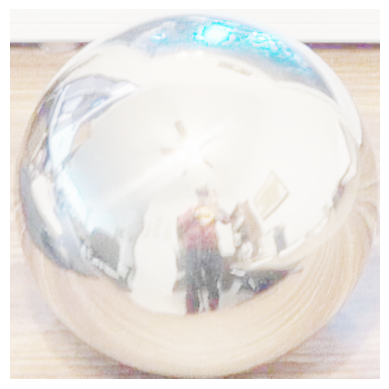

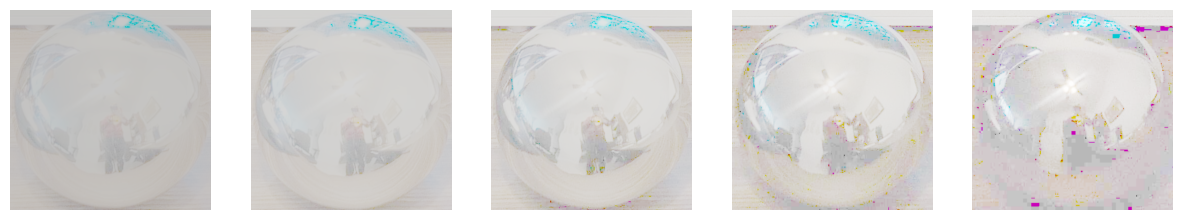

In [7]:
# get HDR image, log irradiance
weighted_hdr_image, weighted_log_irradiances = make_hdr_weighted(ldr_images, exposure_times)

# write HDR image to directory
write_hdr_image(weighted_hdr_image, data_directory / "outputs" / "weighted.hdr")

# display HDR image
display_hdr_image(weighted_hdr_image)
display_images_linear_rescale(weighted_log_irradiances)

Display of difference between naive and weighted for your own inspection

Where does the weighting make a big difference increasing or decreasing the irradiance estimate?  Think about why.

Min ratio =  0.39736113783449745   Max ratio =  5.000000000000001


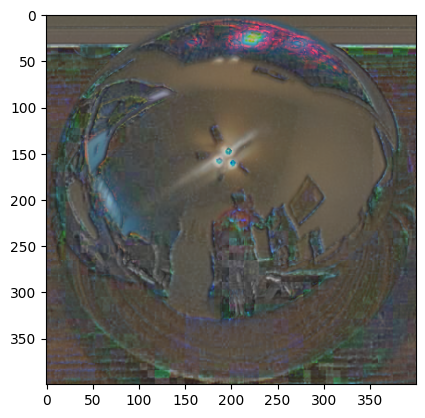

In [8]:
# display difference between naive and weighted

log_diff_im = np.log(weighted_hdr_image) - np.log(naive_hdr_image)
print(
    "Min ratio = ",
    np.exp(log_diff_im).min(),
    "  Max ratio = ",
    np.exp(log_diff_im).max(),
)
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

### LDR merging with camera response function estimation 

Compute HDR after calibrating the photometric reponses to obtain more accurate irradiance estimates from each image

Some suggestions on using <tt>gsolve</tt>:
<ul>
	<li>When providing input to gsolve, don't use all available pixels, otherwise you will likely run out of memory / have very slow run times. To overcome, just randomly sample a set of pixels (1000 or so can suffice), but make sure all pixel locations are the same for each exposure.</li>
	<li>The weighting function w should be implemented using Eq. 4 from the paper (this is the same function that can be used for the previous LDR merging method).</li>
	<li>Try different lambda values for recovering <i>g</i>. Try lambda=1 initially, then solve for <i>g</i> and plot it. It should be smooth and continuously increasing. If lambda is too small, g will be bumpy.</li>
	<li>Refer to Eq. 6 in the paper for using g and combining all of your exposures into a final image. Note that this produces log irradiance values, so make sure to exponentiate the result and save irradiance in linear scale.</li>
</ul>

In [9]:
def make_hdr_estimation(
    ldr_images: np.ndarray, exposure_times: list, lm
) -> tuple[np.ndarray, np.ndarray]:
    """
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    Please refer to problem notebook for how to do it.

    **IMPORTANT**
    The gsolve operations should be ran with:
        Z: int64 array of shape N x P, where N = number of images, P = number of pixels
        B: float32 array of shape N, log shutter times
        l: lambda; float to control amount of smoothing
        w: function that maps from float intensity to weight
    The steps to implement:
    1) Create random points to sample (from mirror ball region)
    2) For each exposures, compute g values using samples
    3) Recover HDR image using g values


    Args:
        ldr_images(np.ndarray): N x H x W x 3 shaped numpy array representing
            N ldr images with width W, height H, and channel size of 3 (RGB)
        exposures(list): list of length N, representing exposures of each images.
            Each exposure should correspond to LDR images' exposure value.
        lm (scalar): the smoothing parameter
    Return:
        (np.ndarray): H x W x 3 shaped numpy array representing HDR image merged using
            gsolve
        (np.ndarray): N x H x W x 3 shaped numpy array represending log irradiances
            for each exposures
        (np.ndarray): 3 x 256 shaped numpy array represending g values of each pixel intensities
            at each channels (used for plotting)
    """
    N, H, W, C = ldr_images.shape
    # sanity check
    assert N == len(exposure_times)

    eps = 1e-8
    w_lut = (np.minimum(np.arange(256), 255 - np.arange(256))).astype(np.float64)

    # Ensure uint8 domain for Z in [0,255]
    ldr = ldr_images
    if ldr.dtype != np.uint8:
        ldr = (np.clip(ldr, 0.0, 1.0) * 255.0).astype(np.uint8) if ldr.max() <= 1.0 else ldr.astype(np.uint8)

    # Ln exposure durations
    B = np.log(np.array(exposure_times, dtype=np.float64))  # shape (N,)

    # Sample P pixels (same spatial coords across exposures) for gsolve
    P = min(1000, H * W)
    rng = np.random.default_rng()
    flat_idx = rng.choice(H * W, size=P, replace=False)
    ys, xs = np.divmod(flat_idx, W)

    g_values = np.zeros((3, 256), dtype=np.float64)

    # Solve g per channel
    for ch in range(3):
        # Build Z (N x P) from same spatial points across exposures
        Z = np.empty((N, P), dtype=np.int64)
        for j in range(N):
            Z[j] = ldr[j, ys, xs, ch].astype(np.int64)

        # gsolve returns g (256,) and logE (P,) — we keep only g here
        g_ch, _ = gsolve(Z, B.astype(np.float32), lm, w_lut)  # g_ch length 256
        g_values[ch] = g_ch

    # Reconstruct full HDR via Eq.6 (per channel, all pixels)
    hdr = np.zeros((H, W, 3), dtype=np.float64)
    log_irradiances = np.zeros((N, H, W, 3), dtype=np.float64)

    for ch in range(3):
        # Z_full: (N, H, W) intensities in [0,255]
        Z_full = ldr[..., ch].astype(np.int64)  # (N,H,W)
        w_full = w_lut[Z_full]     # (N,H,W)

        # Lookup g(Z_ij) via LUT; broadcasting B
        gZ = g_values[ch][Z_full]               # (N,H,W)
        gZ_minus_B = gZ - B.reshape(N, 1, 1)    # (N,H,W)

        # Save per-exposure log irradiances
        log_irradiances[..., ch] = gZ_minus_B

        # Weighted combine (Eq.6)
        num = np.sum(w_full * gZ_minus_B, axis=0)             # (H,W)
        den = np.sum(w_full, axis=0)                          # (H,W)
        logE = num / np.maximum(den, eps)                     # (H,W)
        hdr[..., ch] = np.exp(logE)                           # linear irradiance

    return hdr, log_irradiances, g_values

    # TO DO: implement HDR estimation using gsolve
    # gsolve(Z, B, l, w) -> g, lE

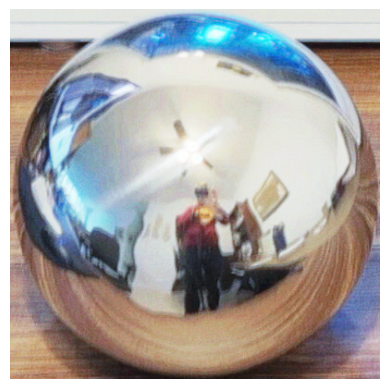

In [10]:
lm = 5
# get HDR image, log irradiance
calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(
    ldr_images, exposure_times, lm
)

# write HDR image to directory
write_hdr_image(calib_hdr_image, data_directory / "outputs" / "calib.hdr")

# display HDR image
display_hdr_image(calib_hdr_image)

The following code displays your results. You can copy the resulting images and plots directly into your report where appropriate.

Min ratio =  0.03256168625490549   Max ratio =  44.69645504888938


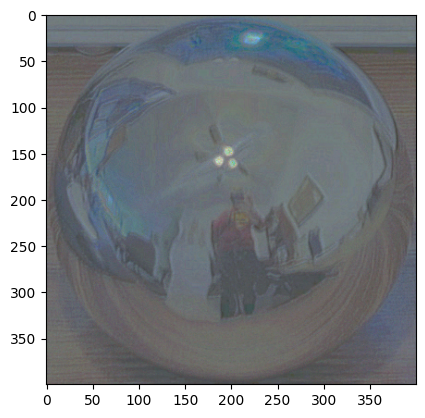

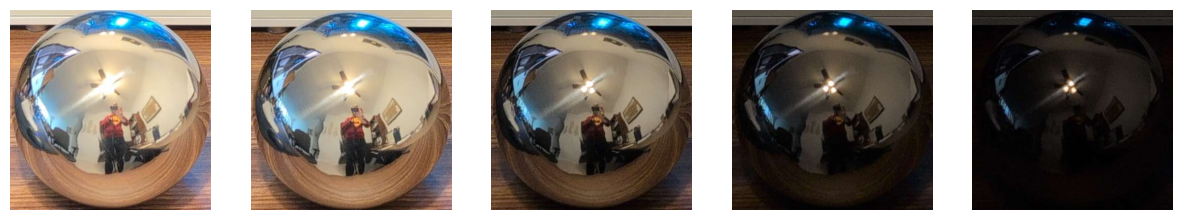

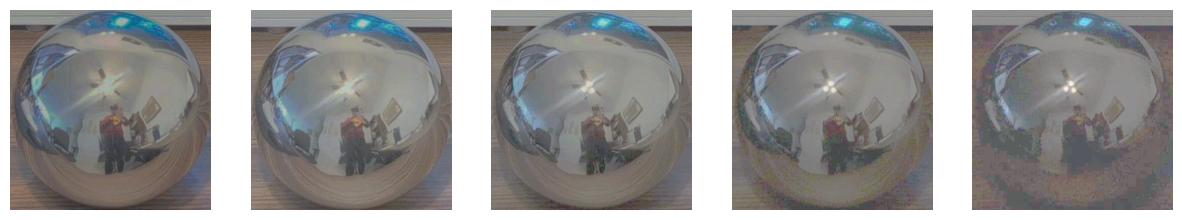

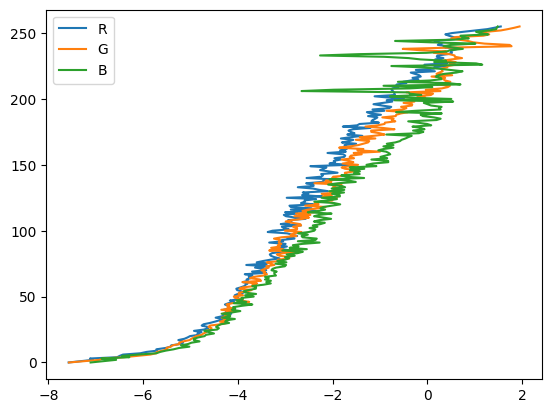

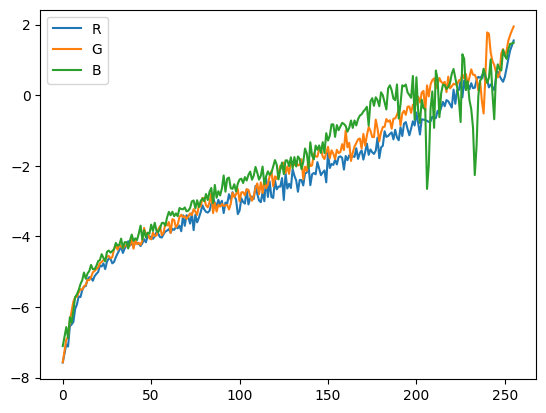

In [11]:
# display difference between calibrated and weighted
log_diff_im = np.log(calib_hdr_image / calib_hdr_image.mean()) - np.log(
    weighted_hdr_image / weighted_hdr_image.mean()
)
print(
    "Min ratio = ",
    np.exp(log_diff_im).min(),
    "  Max ratio = ",
    np.exp(log_diff_im).max(),
)
plt.figure()
plt.imshow(rescale_images_linear(log_diff_im))

# display original images (code provided in utils.display)
display_images_linear_rescale(ldr_images)

# display log irradiance image (code provided in utils.display)
display_images_linear_rescale(calib_log_irradiances)

# plot g vs intensity, and then plot intensity vs g
N, NG = g.shape
labels = ["R", "G", "B"]
plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.gca().legend(("R", "G", "B"))

plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.gca().legend(("R", "G", "B"))

naive:  	log range =  7.897 	avg RMS error =  0.634
weighted:	log range =  7.718 	avg RMS error =  0.637
calibrated:	log range =  13.519 	avg RMS error =  0.415


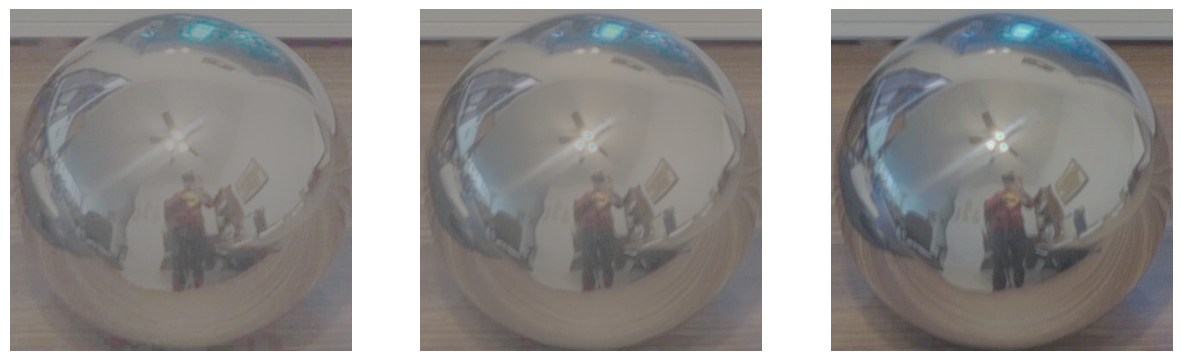

In [12]:
def weighted_log_error(ldr_images, hdr_image, log_irradiances):
    # computes weighted RMS error of log irradiances for each image compared to final log irradiance
    N, H, W, C = ldr_images.shape
    w = 1 - abs(ldr_images - 0.5) * 2
    err = 0
    for n in np.arange(N):
        err += (
            np.sqrt(
                np.multiply(w[n], (log_irradiances[n] - np.log(hdr_image)) ** 2).sum()
                / w[n].sum()
            )
            / N
        )
    return err


# compare solutions
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print(
    "naive:  \tlog range = ",
    round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(), 3),
    "\tavg RMS error = ",
    round(err, 3),
)
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print(
    "weighted:\tlog range = ",
    round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(), 3),
    "\tavg RMS error = ",
    round(err, 3),
)
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print(
    "calibrated:\tlog range = ",
    round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(), 3),
    "\tavg RMS error = ",
    round(err, 3),
)

# display log hdr images (code provided in utils.display)
display_images_linear_rescale(
    np.log(
        np.stack(
            (
                naive_hdr_image / naive_hdr_image.mean(),
                weighted_hdr_image / weighted_hdr_image.mean(),
                calib_hdr_image / calib_hdr_image.mean(),
            ),
            axis=0,
        )
    )
)

## Panoramic transformations 

Compute the equirectangular image from the mirrorball image

In [13]:
def panoramic_transform(hdr_image):
    """
    Given HDR mirror ball image,

    Expects mirror ball image to have center of the ball at center of the image, and
    width and height of the image to be equal.

    Steps to implement:
    1) Compute N image of normal vectors of mirror ball
    2) Compute R image of reflection vectors of mirror ball
    3) Map reflection vectors into spherical coordinates
    4) Interpolate spherical coordinate values into equirectangular grid.

    Steps 3 and 4 are implemented for you with get_equirectangular_image

    """
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3

    # [ADD] build normalized image grid in [-1, 1] with center at (0,0)
    r = (W - 1) / 2.0
    cx = cy = r
    xs = (np.arange(W) - cx) / r
    ys = (np.arange(H) - cy) / r
    X, Y = np.meshgrid(xs, ys)
    rho2 = X**2 + Y**2
    mask = rho2 <= 1.0

    # [ADD] sphere Z and per-pixel normals N (outward), fill outside with 0 for display
    Z = np.zeros_like(X)
    Z[mask] = np.sqrt(1.0 - rho2[mask])
    N = np.dstack((X, Y, Z))  # shape (H, W, 3)

    # [ADD] reflection vectors: R = V - 2 * dot(V,N) * N, with V=(0,0,-1)
    V = np.array([0.0, 0.0, -1.0], dtype=np.float64)
    Vimg = np.broadcast_to(V, N.shape)
    dotVN = np.sum(Vimg * N, axis=2, keepdims=True)
    R = Vimg - 2.0 * dotVN * N

    # [ADD] normalize R and set a harmless value outside the sphere to avoid NaNs in griddata
    R /= np.maximum(np.linalg.norm(R, axis=2, keepdims=True), 1e-8)
    R[~mask] = np.array([0.0, 1.0, 0.0])  # maps to theta=pi (south pole), gets ignored by interpolation

    # R = V - 2 * dot(V,N) * N

    plt.imshow((N + 1) / 2)
    plt.show()
    plt.imshow((R + 1) / 2)
    plt.show()

    equirectangular_image = get_equirectangular_image(R, hdr_image)

    # This just makes the image brighter
    eps = 1e-8
    Ylin = 0.2126*equirectangular_image[...,0] + 0.7152*equirectangular_image[...,1] + 0.0722*equirectangular_image[...,2]
    scale = np.percentile(Ylin[Ylin>0], 99.0) if np.any(Ylin>0) else 1.0
    im = equirectangular_image / max(scale, eps)
    im_disp = im / (1.0 + im)           # simple Reinhard
    im_disp = np.clip(im_disp, 0, 1)

    plt.imshow(np.power(im_disp, 1/2.2)); plt.axis("off"); plt.show()
    return equirectangular_image

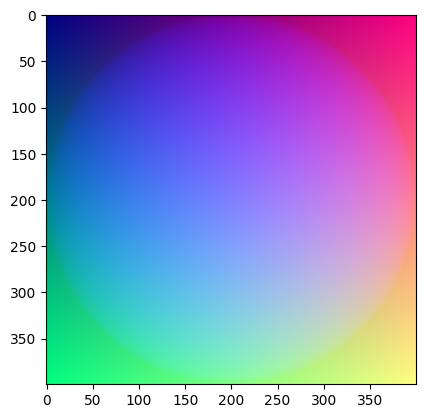

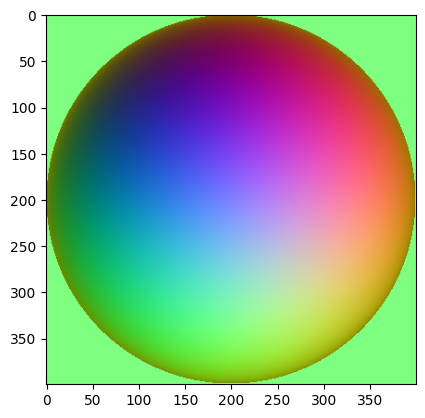

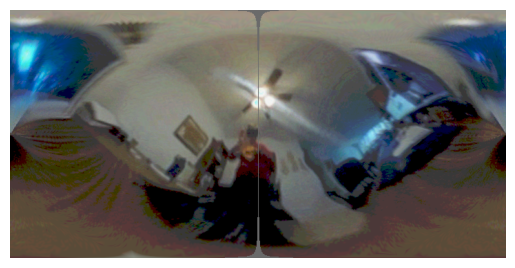

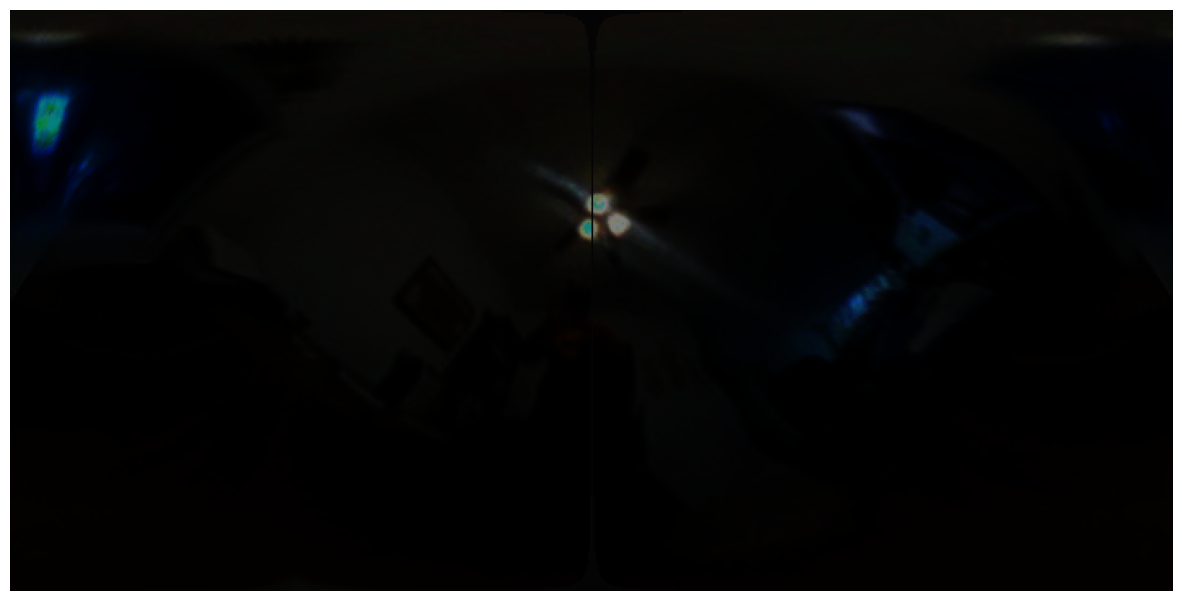

In [14]:
hdr_mirrorball_image = read_hdr_image(data_directory / "outputs" / "calib.hdr")
eq_image = panoramic_transform(hdr_mirrorball_image)

write_hdr_image(eq_image, data_directory / "outputs" / "equirectangular.hdr")

plt.figure(figsize=(15, 15))
display_hdr_image(eq_image)


---

## Rendering synthetic objects into photographs 

Use Blender to render the scene with and with objects and obtain the mask image.  The code below should then load the images and create the final composite.

In [15]:
# Read the images that you produced using Blender.  Modify names as needed.
O = read_image("images/proj4_objects.png")
E = read_image("images/proj4_empty.png")
M = read_image("images/proj4_mask.png")
M = M > 0.5
I = background_image
I = cv2.resize(I, (M.shape[1], M.shape[0]))

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# TO DO: compute final composite
result = []

plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.show()

write_image(result, "images/outputs/final_composite.png")

---


## Bells & Whistles (Extra Points)

### Additional Image-Based Lighting Result 


### Other panoramic transformations 


### Photographer/tripod removal 


### Local tonemapping operator 

